## Amortised Inference for a Beta Posterior Distribution

In this notebook, we always consider the following setup:

We observe data $y$ that we assume was generated by some model $M$ with parameters $\theta$.  
Our goal is to learn the posterior distribution $\pi(\theta \mid y)$ , i.e. either to draw samples from it or to evaluate its density.

We make three key assumptions:

1. **Prior:** $\theta$ follows a chosen prior distribution, $\pi(\theta)$.  
2. **Intractable likelihood:** The likelihood $\pi(y \mid \theta)$ cannot be computed in closed form.  
3. **Generative simulator:** We can still draw samples from the model, i.e.\ simulate $y \sim \pi(y \mid \theta)$.

With these in place, we’ll use **amortised inference** methods to approximate $\pi(\theta \mid y)$ despite the intractable likelihood.



In [1]:
'''
What we do:
    
prior Beta(2,5) → Binomial data.
First compute empirical posterior means/variances for every y.
Treat the empirical μ and log var as regression targets.
Train a small net (2-output) with MSE loss on (μ, log σ) directly.
Visualize both the μ‐vs‐y curve and the final posterior comparison.
'''

from scipy.stats import norm, poisson, beta, binom
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict

# Reproducibility settings
SEED = 123
random.seed(SEED)         # seed Python RNG
np.random.seed(SEED)      # seed NumPy RNG
torch.manual_seed(SEED)   # seed PyTorch RNG
# Optional: make cuDNN deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

##### Generative Model and Simulation Procedure

We begin with a Binomial data‐generation process:

- **Data:**  
  $$
  y \sim \mathrm{Binomial}(n=100, \theta),
  $$
  where $y$ is the number of successes out of 100 trials.

- **Prior:**  
  $$
  \theta \sim \mathrm{Beta}(2, 5).
  $$

Our simulation‐based inference workflow:

1. Draw $M$ samples $\{\theta^{(i)}\}_{i=1}^M$ from the prior $\mathrm{Beta}(2, 5)$.  
2. For each $\theta^{(i)}$, simulate one dataset:  
   $$
   y^{(i)} \sim \mathrm{Binomial}(100, \theta^{(i)}).
   $$
3. Assemble a table of simulated pairs  
   $$
   \bigl(\theta^{(i)},\,y^{(i)}\bigr)_{i=1}^M,
   $$
   which will serve as the training data for our amortised inference network.


In [2]:
# the prior is beta distribution
alpha = 2
beta_para = 5

# number of samples
M = 10**6

# binomial distribution
success = 80
n_trials = 100

# First sample theta form Beta(2,5)
theta_samples = beta.rvs(alpha, beta_para, size=M)
# Then for each theta, generate the binomial , also 

y_samples = binom.rvs(n=n_trials, p = theta_samples)

# Now you have (θ, x) pairs
# print("First 5 theta values:", theta_samples[:5])
# print("First 5 x values:", y_samples[:5])

theta_np = theta_samples.reshape(-1,1)
y_np = y_samples.reshape(-1,1)

# Combine  theta_np and y_np together
out_mat = np.column_stack([theta_samples, y_samples])
# Create a list of theta
theta_dict = defaultdict(list)
sel_index = (out_mat[:, 1] == 1) 
# print(sel_index)
for i in range(n_trials + 1):  # y ∈ [0, n_trials]
    sel_index = (out_mat[:, 1] == i)         # select rows where y == i
    theta_vals = out_mat[sel_index, 0]       # get corresponding θ
    theta_dict[i] = theta_vals               # store as list or array
# print(theta_dict)

##### Posterior Summary Statistics and Visualization

Next, for each possible observation $y \in \{0,1,\dots,100\}$:

1. Collect the set of simulated parameters:
   $$
   \{\theta^{(i)} : y^{(i)} = y\}
   $$
2. Compute the posterior mean:
   $$
   \mathbb{E}[\theta \mid y] = \frac{1}{N_y} \sum_{i:\,y^{(i)}=y} \theta^{(i)},
   $$
   where $N_y$ is the number of simulations with $y^{(i)}=y$.
3. Compute the posterior variance:
   $$
   \mathrm{Var}[\theta \mid y] = \frac{1}{N_y} \sum_{i:\,y^{(i)}=y} \bigl(\theta^{(i)} - \mathbb{E}[\theta \mid y]\bigr)^2.
   $$
4. Assemble a table with columns:
   $$
   (y,\; \theta,\;\mathbb{E}[\theta\mid y],\;\mathrm{Var}[\theta\mid y]).
   $$

Finally, visualize the results by plotting:

- $y \mapsto \mathbb{E}[\theta \mid y]$ (posterior mean curve)
- $y \mapsto \mathrm{Var}[\theta \mid y]$ (posterior variance curve)

C:\Users\gogot\anaconda3\envs\pytorch311\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\gogot\anaconda3\envs\pytorch311\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\gogot\anaconda3\envs\pytorch311\Lib\site-packages\numpy\_core\fromnumeric.py:4008: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gogot\anaconda3\envs\pytorch311\Lib\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\gogot\anaconda3\envs\pytorch311\Lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


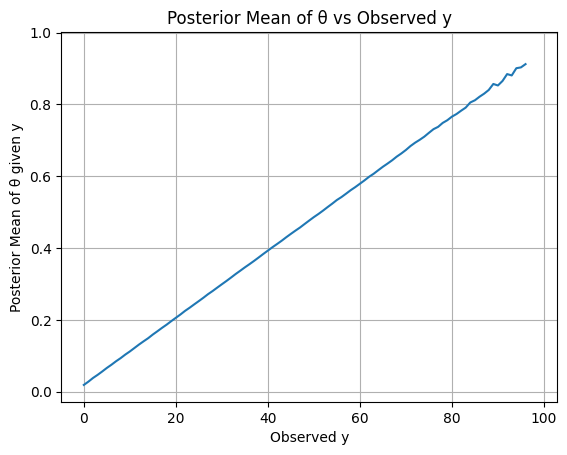

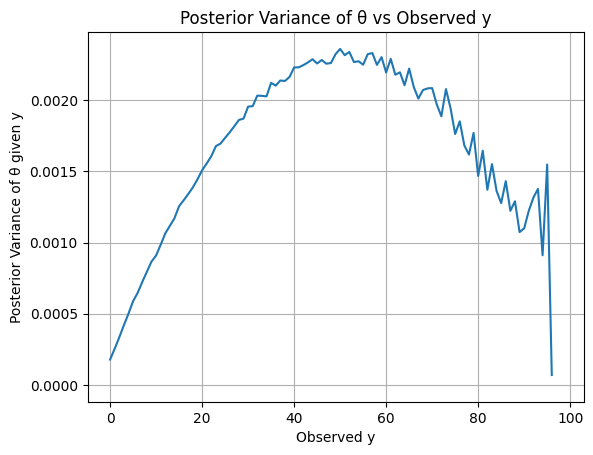

In [3]:
# Now calculate the mean and variance of theta list
post_means = {}
post_vars = {}

for i in theta_dict:
    thetas = np.array(theta_dict[i])
    post_means[i] = np.mean(thetas)
    post_vars[i] = np.var(thetas)

# Plot Expectatiion versus y
y_vals = list(range(n_trials + 1))  # y = 0 to 100
exp_vals = [post_means[y] for y in y_vals]

plt.plot(y_vals, exp_vals)
plt.xlabel("Observed y")
plt.ylabel("Posterior Mean of θ given y")
plt.title("Posterior Mean of θ vs Observed y")
plt.grid(True)
plt.show()

var_vals = [post_vars[y] for y in y_vals]

# Plot Var(\t)
plt.plot(y_vals, var_vals)
plt.xlabel("Observed y")
plt.ylabel("Posterior Variance of θ given y")
plt.title("Posterior Variance of θ vs Observed y")
plt.grid(True)
plt.show()

##### Preparing Training Data from Summary Statistics

Convert the posterior summaries into input–output pairs:

1. For each $y$, let
   $$
     \mu = \mathbb{E}[\theta \mid y],\quad
     \mathrm{Var}(\theta \mid y).
   $$
   Keep only cases with $\mathrm{Var}>0$.

2. Build arrays:
   - $x_{\text{list}} = [\,y\,]$
   - $y_{\text{list}} = \bigl[\mu,\;\tfrac12\log(\mathrm{Var})\bigr]$

3. Convert to tensors:
   $$
   x = \mathrm{torch.tensor}(x\_np,\ \mathrm{dtype}=\mathrm{torch.float32}),\quad
   y = \mathrm{torch.tensor}(y\_np,\ \mathrm{dtype}=\mathrm{torch.float32}).
   $$

##### Defining the Probabilistic Neural Network

We map $y \mapsto (\hat\mu,\,\widehat{\log\sigma})$ via an MLP, then recover
$$
\hat\sigma = \exp\bigl(\widehat{\log\sigma}\bigr).
$$

##### Training & Evaluation

- **Loss:** $\mathrm{MSE}(\hat\mu,\mu) \;+\; \mathrm{MSE}(\widehat{\log\sigma},\log\sigma)$  
- **Optimizer:** Adam with $\mathrm{lr}=0.01$  
- **Epochs:** 1000 (print every 100)

For a new observation $y_{\mathrm{obs}}$:

1. Predict: $(\hat\mu,\,\widehat{\log\sigma}) = \mathrm{model}(y_{\mathrm{obs}})$  
2. True posterior: $\theta\mid y_{\mathrm{obs}}\sim\mathrm{Beta}(\alpha+y_{\mathrm{obs}},\ \beta+n-y_{\mathrm{obs}})$  
3. Plot both densities:
   - True: Beta density  
   - Approx: $\mathcal{N}(\hat\mu,\hat\sigma^2)$  


Epoch 0, Loss: 34.21888
Epoch 100, Loss: 0.03398
Epoch 200, Loss: 0.01995
Epoch 300, Loss: 0.01890
Epoch 400, Loss: 0.04600
Epoch 500, Loss: 0.02277
Epoch 600, Loss: 0.02146
Epoch 700, Loss: 0.01964
Epoch 800, Loss: 0.01928
Epoch 900, Loss: 0.01934
Posterior for y=80 → N(mean=0.4895, std=0.0471)


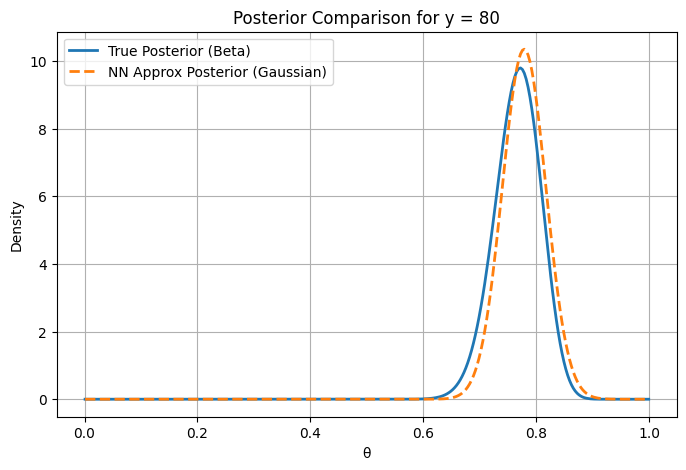

In [4]:
# convert our post_mean and post variance into list 

x_list = []      # y values (input)
y_list = []      # [mean, log_variance] (output)

for y_val in sorted(post_means.keys()):
    mu = post_means[y_val]
    var = post_vars[y_val]
    if var>0:
        # var = max(var, 1e-6)
        x_list.append([y_val])
        y_list.append([mu, 0.5 * np.log(var)])

x_np = np.array(x_list, dtype=np.float32)      # shape (N, 1)
y_np = np.array(y_list, dtype=np.float32)      # shape (N, 2)

x = torch.tensor(x_np, dtype=torch.float32)  # shape (N, 1)
y = torch.tensor(y_np, dtype=torch.float32)  # shape (N, 2)

# We use MSE loss
mse = nn.MSELoss()

# Define the deep neural network
class ProbabilisticNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 24),
            nn.ReLU(),
            nn.Linear(24 ,25),
            nn.ReLU(),
            nn.Linear(25, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
    def forward(self, x):
        out = self.net(x)
        mu = out[:, 0:1]
        log_sigma = out[:, 1:2]  # Predict log(σ) to ensure positivity
        return mu, log_sigma
        
model = ProbabilisticNN()
# Define what our optimizer is
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Extract training targets
y_target = y[:, 0:1]            # true mean
log_var_target = y[:, 1:2]      # true log variance

for epoch in range(1000):  # do 1000 passes over the data
    model.train()  # set model to training mode

    mu_pred, log_sigma_pred = model(x)  # forward pass: compute predictions

    loss_mu = mse(mu_pred, y_target)
    loss_logvar = mse(log_sigma_pred, log_var_target)
    loss = loss_mu + loss_logvar  # compute loss (MSE between prediction and true y)

    optimizer.zero_grad()  # clear previous gradients
    loss.backward()        # backpropagation: compute gradients
    optimizer.step()       # update weights using optimizer

    # Optional: print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")
      
#  Plot our training results
model.eval()
x_obs = torch.tensor([[50.0]], dtype=torch.float32)
mu_pred, log_sigma_pred = model(x_obs)

mu_val = mu_pred.item()
sigma_val = torch.exp(log_sigma_pred).item()

print(f"Posterior for y=80 → N(mean={mu_val:.4f}, std={sigma_val:.4f})")

# Draw the true distribution and our approximated distribution at the same time
alpha, beta_para = 2, 5
n = 100
y_obs = 80
true_posterior = beta(a=alpha + y_obs, b=beta_para + n - y_obs)

# Our approximated distribution
x_obs = torch.tensor([[y_obs]], dtype=torch.float32)
mu_pred, log_sigma_pred = model(x_obs)
mu_val = mu_pred.item()
sigma_val = torch.exp(log_sigma_pred).item()


# Plot both
theta_range = np.linspace(0.001, 0.999, 300)

# True posterior density
true_pdf = true_posterior.pdf(theta_range)

# Neural approximation
approx_pdf = norm.pdf(theta_range, loc=mu_val, scale=sigma_val)

# Plot both
plt.figure(figsize=(8,5))
plt.plot(theta_range, true_pdf, label="True Posterior (Beta)", lw=2)
plt.plot(theta_range, approx_pdf, label="NN Approx Posterior (Gaussian)", lw=2, linestyle="--")
plt.title(f"Posterior Comparison for y = {y_obs}")
plt.xlabel("θ")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

##### Remarks

In this Binomial–Beta example, our network approximates each posterior $\pi(\theta\mid y)$ by a Gaussian $\mathcal{N}(\hat\mu,\hat\sigma^2)$. While this works well near the center, the fit degrades in the tails, particularly when $y$ is close to $0$ or $n$. In those cases, the true posterior
$$
\theta\mid y \sim \mathrm{Beta}(\alpha + y,\;\beta + n - y)
$$
is highly skewed and bounded on $[0,1]$, whereas a Gaussian is symmetric and unbounded. Consequently, the Gaussian approximation tends to:

- Underestimate density near the boundaries $0$ and $1$  
- Overestimate tail probabilities outside the true support  
- Fail to capture the skewness of the Beta distribution  

**Next,** we’ll examine how this method performs with a different loss function - we maximise the likelihood of the observed data rather than minimising the Mean Squared Error (MSE).

In [5]:
# --- Improved Network & Log‐Likelihood Training (no need to re-define data/summaries) ---

# Precompute constant for Gaussian log-likelihood
log_2pi = math.log(2 * math.pi)

# Define the MDN-style network with separate mean_net and log_var_net
class ProbabilisticNN_LL(nn.Module):
    def __init__(self):
        super().__init__()
        # Sub-network for predicting the mean μ
        self.mean_net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )
        # Sub-network for predicting the log-variance log σ²
        self.log_var_net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        mu      = self.mean_net(x)
        log_var = self.log_var_net(x)
        return mu, log_var

# Instantiate model and optimizer
model_ll = ProbabilisticNN_LL()
optimizer_ll = optim.Adam(model_ll.parameters(), lr=0.01)

# Training loop: maximize total Gaussian log-likelihood across y = 0…n_trials
for epoch in range(1000):
    model_ll.train()
    total_loglik = 0.0

    for y_val in range(n_trials + 1):
        # skip degenerate or empty cases
        if post_vars[y_val] == 0:
            continue

        # normalize input
        x_in = torch.tensor([[y_val / n_trials]], dtype=torch.float32)
        mu_pred, log_var_pred = model_ll(x_in)
        var_pred = torch.exp(log_var_pred)

        # true θ draws for this y
        theta_tensor = torch.tensor(theta_dict[y_val], dtype=torch.float32).view(-1,1)

        # Gaussian log-probability: −½[log(2π) + log σ² + (θ−μ)²/σ²]
        log_probs = -0.5 * (
            log_2pi
            + log_var_pred
            + (theta_tensor - mu_pred)**2 / var_pred
        )
        total_loglik += log_probs.sum()

    # loss = negative log-likelihood
    loss_ll = -total_loglik
    optimizer_ll.zero_grad()
    loss_ll.backward()
    optimizer_ll.step()

    if epoch % 100 == 0:
        print(f"[LL] Epoch {epoch}, Loss: {loss_ll.item():.5f}")
           


[LL] Epoch 0, Loss: 929258.81250
[LL] Epoch 100, Loss: -1757586.75000
[LL] Epoch 200, Loss: -1798407.50000
[LL] Epoch 300, Loss: -1778857.25000
[LL] Epoch 400, Loss: -1802757.37500
[LL] Epoch 500, Loss: -1795840.12500
[LL] Epoch 600, Loss: -1802177.62500
[LL] Epoch 700, Loss: -1803289.87500
[LL] Epoch 800, Loss: -1803535.37500
[LL] Epoch 900, Loss: -1803537.62500


Posterior for y=80 → N(mean=0.7585, std=0.0673)


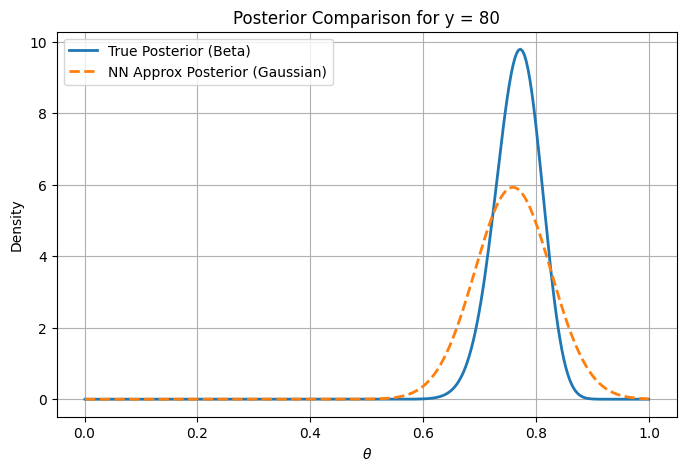

In [6]:
# Plot our training results with correct input normalization
model_ll.eval()

# Parameters
alpha, beta_para = 2, 5
n_trials = 100

# Choose observation and normalize input
y_obs = 80
x_obs = torch.tensor([[y_obs / n_trials]], dtype=torch.float32)  # **normalize by n_trials**

# Predict posterior mean and std for normalized input
mu_pred, log_sigma_pred = model_ll(x_obs)
mu_val = mu_pred.item()
sigma_val = torch.exp(log_sigma_pred).item()

with torch.no_grad():
    # Predict approximate posterior parameters for θ | y_obs
    mu_pred, log_var_pred = model_ll(x_obs)
    var_pred = torch.exp(log_var_pred)
    mu_val = mu_pred.item()
    sigma_val = np.sqrt(var_pred.item())

print(f"Posterior for y={y_obs} → N(mean={mu_val:.4f}, std={sigma_val:.4f})")

# True Beta posterior for comparison
true_posterior = beta(a=alpha + y_obs, b=beta_para + n_trials - y_obs)

# Create θ grid
theta_range = np.linspace(0.001, 0.999, 300)

# Compute densities
true_pdf   = true_posterior.pdf(theta_range)
approx_pdf = norm.pdf(theta_range, loc=mu_val, scale=sigma_val)

# Plot densities
plt.figure(figsize=(8, 5))
plt.plot(theta_range,   true_pdf,   label="True Posterior (Beta)",        lw=2)
plt.plot(theta_range,   approx_pdf, label="NN Approx Posterior (Gaussian)", lw=2, linestyle="--")
plt.title(f"Posterior Comparison for y = {y_obs}")
plt.xlabel(r"$\theta$")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()



##### Observations on Gaussian vs MSE Training

We observe that, especially for extreme values of $y$, training with the Gaussian log‐likelihood loss yields worse approximations than using MSE on \$(\bigl(\mu,\;\log\sigma\bigr)\)$. This is likely because a Gaussian is a poor approximator of the true posterior

$$
\theta \;\bigm|\; y 
\;\sim\; \mathrm{Beta}(\alpha + y,\;\beta + n - y),
$$

which is often skewed and has support only on $[0,1]$, whereas a Gaussian is symmetric and unbounded.

---

##### Next: Beta‐Distributed Approximation

To better capture both the bounded support and skewness, we now approximate the posterior by a Beta distribution

$$
\theta \;\bigm|\; y
\;\approx\;
\mathrm{Beta}\bigl(\alpha'(y),\,\beta'(y)\bigr),
$$

which we expect to fit the empirical posteriors much more accurately.  


Generating data...
Training model...
Epoch 0, Loss: 108516.8203
Epoch 100, Loss: -1183358.3750
Epoch 200, Loss: -1533913.6250
Epoch 300, Loss: -1716773.3750
Epoch 400, Loss: -1810818.2500
Epoch 500, Loss: -1858137.5000
Epoch 600, Loss: -1879589.8750
Epoch 700, Loss: -1891821.7500
Epoch 800, Loss: -1896190.2500
Epoch 900, Loss: -1897833.3750


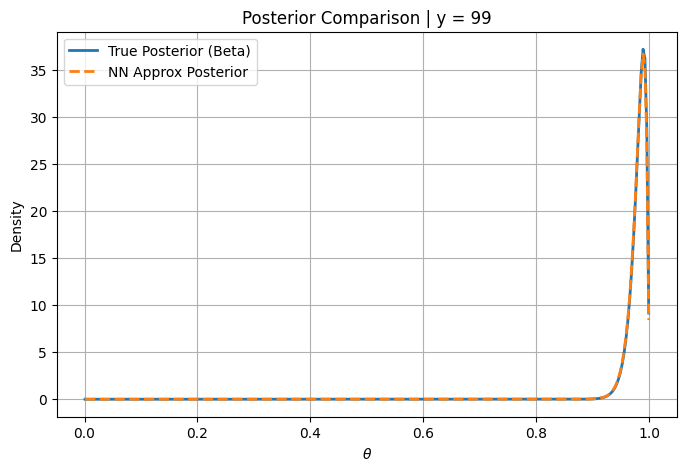

In [9]:
class BetaPosteriorNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha_net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Softplus()  # Ensure alpha > 0
        )
        self.beta_net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Softplus()  # Ensure beta > 0
        )

    def forward(self, x):
        alpha = self.alpha_net(x)
        beta = self.beta_net(x)
        return alpha, beta

# ============================== #
#      3. Data Generation
# ============================== #
def simulate_beta_binomial_data(M, n_trials, alpha, beta_param):
    """
    Generate M samples from:
        θ ~ Beta(alpha, beta)
        y ~ Binomial(n_trials, θ)
    Returns:
        theta_samples: (M, 1)
        y_samples: (M, 1)
    """
    theta_samples = beta.rvs(a=alpha, b=beta_param, size=M)
    y_samples = binom.rvs(n=n_trials, p=theta_samples)
    return theta_samples.reshape(-1, 1), y_samples.reshape(-1, 1)

# ============================== #
#      4. Group theta by y
# ============================== #
def group_theta_by_y(theta_samples, y_samples):
    """
    Group theta samples by unique y values
    Returns: dict { y_val : [theta_list] }
    """
    data = np.column_stack([theta_samples.squeeze(), y_samples.squeeze()])
    theta_dict = defaultdict(list)
    for y in np.unique(y_samples):
        theta_dict[y] = data[data[:,1] == y, 0]
    return theta_dict

# ============================== #
#      5. Train Neural Network
# ============================== #
def train_model(model, theta_dict, y_max, epochs=300, lr=1e-2):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        total_log_likelihood = 0.0
        model.train()
        for y_val, theta_vals in theta_dict.items():
            if len(theta_vals) < 20:
                continue
            x = torch.tensor([[y_val / y_max]], dtype=torch.float32)
            theta = torch.tensor(theta_vals, dtype=torch.float32).view(-1, 1)
            theta = torch.clamp(theta, 1e-6, 1 - 1e-6)
            alpha_pred, beta_pred = model(x)

            log_probs = (
                (alpha_pred - 1) * torch.log(theta) +
                (beta_pred - 1) * torch.log(1 - theta) -
                torch.lgamma(alpha_pred) - torch.lgamma(beta_pred) +
                torch.lgamma(alpha_pred + beta_pred)
            )
            total_log_likelihood += log_probs.sum()
        
        loss = -total_log_likelihood
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ============================== #
#      6. Visualize Posterior
# ============================== #
def plot_posterior_comparison(model, y_obs, n_trials, prior_alpha, prior_beta, y_max):
    x = torch.tensor([[y_obs / y_max]], dtype=torch.float32)
    with torch.no_grad():
        alpha_pred, beta_pred = model(x)
    alpha_val = alpha_pred.item()
    beta_val = beta_pred.item()

    # True posterior
    true_posterior = beta(a=prior_alpha + y_obs, b=prior_beta + n_trials - y_obs)

    theta_range = np.linspace(0.001, 0.999, 300)
    true_pdf = true_posterior.pdf(theta_range)
    nn_pdf = beta.pdf(theta_range, a=alpha_val, b=beta_val)

    plt.figure(figsize=(8,5))
    plt.plot(theta_range, true_pdf, label="True Posterior (Beta)", lw=2)
    plt.plot(theta_range, nn_pdf, '--', label="NN Approx Posterior", lw=2)
    plt.title(f"Posterior Comparison | y = {y_obs}")
    plt.xlabel(r"$\theta$")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

# ============================== #
#      7. Main Program
# ============================== #
if __name__ == "__main__":
    # Settings
    prior_alpha = 1
    prior_beta = 1
    M = 10**6
    n_trials = 100

    print("Generating data...")
    theta_samples, y_samples = simulate_beta_binomial_data(M, n_trials, prior_alpha, prior_beta)
    theta_dict = group_theta_by_y(theta_samples, y_samples)
    y_max = y_samples.max()

    model = BetaPosteriorNN()
    print("Training model...")
    train_model(model, theta_dict, y_max, epochs=1000, lr=1e-2)

    # Visualize one case
    y_obs = 99
    plot_posterior_comparison(model, y_obs, n_trials, prior_alpha, prior_beta, y_max)


##### Beta‐Approximation Performance

Even for the most extreme values of $y$, our Beta‐approximation now fits the empirical posterior exceptionally well. This is expected because:

1. We chose a prior  
   $$\theta \sim \mathrm{Beta}(\alpha, \beta),$$

2. We used a Binomial likelihood  
   $$y \sim \mathrm{Binomial}(n, \theta),$$

3. By conjugacy, the true posterior is  
   $$\theta \mid y \sim \mathrm{Beta}(\alpha + y, \beta + n - y),$$

so our approximation family exactly matches the true posterior.

> **Note:** This “hint” relies on knowing the conjugate family in advance. In non‐conjugate settings, we’d need more flexible approximations.  


##### Practical Recommendations

- **Epochs & Convergence:**  
  We observe convergence relatively early in training. A good rule of thumb is to start with **$1000$ epochs**.

- **Learning Rate:**  
  Initial learning rates around **$10^{-2}$** tend to perform best. For more fine‐grained or later‐stage fitting, reducing the learning rate can help refine the approximation.

- **Approximation Choice:**  
  - Gaussian approximations ($\mathcal{N}(\mu,\sigma^2)$) work reasonably well for central values of $y$.  
  - For extreme values of $y$ — and in general — using a Beta approximation ($\mathrm{Beta}(\alpha',\beta')$) yields a more faithful fit to the true, bounded and often skewed posterior.